In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import collections
import itertools

In [2]:
# %load scripts/myarray.py
import numpy as np

# a small set of helper functions to
# call common array creation functions
# these are useful to ensure that
# all arrays are created as double-precision
# floats, no matter what data are provided
# as argument. For example array([1,3,4]) normally returns
# an array with data of type int, but arrayf([1,3,4])
# always creates an array of floats 

kFloatType = np.float64

def arrayf( arg ):
    return np.array( arg, kFloatType )
def asarrayf( arg ):
    return np.asarray( arg, kFloatType )
def zerosf( arg ):
    return np.zeros( arg, kFloatType )
def identityf( arg ):
    return np.identity( arg, kFloatType )
def emptyf( arg ):
    return np.empty( arg, kFloatType )


In [3]:
# %load scripts/springs.py
#from numpy import *
#from myarray import *

## This is the spring constant
k = 1.

## This is our threshold for whether a number is approximately zero.
ZERO_THRESHOLD = 1e-8

def F_ij( p_i, p_j, r_ij ):
    '''
    Returns the force of the spring from 'p_i' to 'p_j' with rest length 'r_ij' acting on 'p_i'.
    Note that F_ij( p_i, p_j, r_ij ) equals -F_ij( p_j, p_i, r_ij ).
    '''

    p_ij = p_i - p_j
    len_p_ij = np.sqrt( sum( p_ij ** 2 ) )

    if abs( len_p_ij ) < ZERO_THRESHOLD:
        result = 0. * p_ij
    else:
        result = -k * ( len_p_ij - r_ij ) / len_p_ij * p_ij

    return result

def F( p, edges, edges_rest_lengths ):
    '''
    Returns a vector containing the force at every point.
    Note that the input 'p' is assumed to be a number-of-points by dimension array, where
    dimension is 2 for our example.  The result is flattened into a single vector
    of size number-of-points times dimension.
    '''

    dim = p.shape[1]

    Fp = zerosf( np.prod( p.shape ) )

    ## Loop over every edge and its corresponding rest length.
    ## (zip() simply combines two lists into one so we can loop over them together.)
    for (i,j), r_ij in zip( edges, edges_rest_lengths ):
        assert i != j

        Fij = F_ij( p[i], p[j], r_ij )

        Fp[ i*dim : (i+1) * dim ] += Fij
        ## 'edges' contains edges uniquely, so 'edges' will contain (i,j) but not (j,i).
        ## This means that we must add -Fij to row j as well as Fij to row i.
        Fp[ j*dim : (j+1) * dim ] += -Fij

    return Fp

def dF_ij_d_p_i( p_i, p_j, r_ij ):
    '''
    Returns the derivative with respect to 'p_i' of the force of the spring
    from 'p_i' to 'p_j' with rest length 'r_ij' acting on 'p_i'.
    Our dimension is 2, so this is a 2x2 quantity.
    Note that dF_ij_d_p_i( p_i, p_j, r_ij ) equals dF_ij_d_p_i( p_j, p_i, r_ij ).
    '''

    dim = p_i.shape[0]

    p_ij = p_i - p_j
    len_p_ij = np.sqrt( sum( p_ij ** 2 ) )
    if abs( len_p_ij ) < ZERO_THRESHOLD:
        result = -k * np.identity( dim )
    else:
        result = -k * np.identity( dim ) - k * r_ij / len_p_ij**3 * np.outer( p_ij, p_ij ) + k * r_ij / len_p_ij * np.identity( dim )
    return result

def J( p, edges, edges_rest_lengths ):
    '''
    Returns a matrix containing the derivative of the force at every point with respect to each point.
    Note that the input 'p' is assumed to be a number-of-points by dimension array, where
    dimension is 2 for our example.
    The result is flattened is a square matrix (of type numpy.array), of size NxN, where
    N = number-of-points times dimension.
    '''

    dim = p.shape[1]

    Jp = zerosf( ( np.prod( p.shape ), np.prod( p.shape ) ) )

    ## Loop over every edge and its corresponding rest length.
    ## (zip() simply combines two lists into one so we can loop over them together.)
    for (i,j), r_ij in zip( edges, edges_rest_lengths ):
        assert i != j

        dF = dF_ij_d_p_i( p[i], p[j], r_ij )
        assert ( ( Jp[ i*dim : (i+1) * dim, j*dim : (j+1) * dim ] - np.zeros( ( dim, dim ) ) ) ** 2 ).sum().sum() == 0.

        Jp[ i*dim : (i+1) * dim, j*dim : (j+1) * dim ] = -dF
        Jp[ i*dim : (i+1) * dim, i*dim : (i+1) * dim ] += dF
        ## 'edges' contains edges uniquely, so 'edges' will contain (i,j) but not (j,i).
        ## This means that we must add dF to the right places in column j as well.
        Jp[ j*dim : (j+1) * dim, i*dim : (i+1) * dim ] = -dF
        Jp[ j*dim : (j+1) * dim, j*dim : (j+1) * dim ] += dF

    return Jp

def constrain_system( A, rhs, rows ):
    '''
    This function modifies its input parameters, a system matrix 'A' and
    right-hand-side vector 'rhs', such that for every index i in 'rows',
    the row i of A is set to row i of the identity matrix and rhs[i] is set to zero.
    '''

    for i in rows:
        A[ i, : ] = np.zeros( A.shape[1] )
        ## We can also zero the column, which keeps the matrix symmetric, because
        ## we are zeroing the corresponding entries in the right-hand-side (x*0 = 0).
        A[ :, i ] = np.zeros( A.shape[0] )
        A[ i, i ] = 1
        rhs[i] = 0

    return A, rhs

def static_solution( p, edges, edges_rest_lengths, constraints, verbose = True ):
    '''
    Given a list of points 'p' as an n-by-2 array, a list of (i,j) pairs 'edges' denoting an edge
    between points p[i] and p[j], a list of rest lengths (one for each edge in 'edges'),
    and a list of position constraints (i, position) denoting p[i] = position,
    uses Newton's method to solve for the positions where the forces are all zero.

    NOTE: 'edges' must not have both (i,j) and (j,i)
    '''

    XSTEP_THRESHOLD = 1e-5
    F_THRESHOLD = 1e-8
    MAX_ITERATIONS = 100

    p_n = p.copy().flatten()
    dim = p.shape[1]

    constrain_rows = []
    for i, p_val in constraints:
        p_n[ i*dim : (i+1) * dim ] = p_val
        constrain_rows.extend( range( i*dim, (i+1) * dim ) )

    iteration = 0
    while True:
        if verbose: print '-- iteration', iteration, '--'
        iteration += 1

        Jp_n = J( p_n.reshape( p.shape ), edges, edges_rest_lengths )
        Fp_n = F( p_n.reshape( p.shape ), edges, edges_rest_lengths )
        mag2_Fp_n = sum( Fp_n ** 2 )
        if verbose: print '| F( p_n ) |^2:', mag2_Fp_n
        if mag2_Fp_n < F_THRESHOLD: break

        constrain_system( Jp_n, Fp_n, constrain_rows )

        # p_n_p_1 = p_n - dot( linalg.inv( Jp_n ), Fp_n )
        ## <=> p_n_p_1 - p_n = -linalg.inv( Jp_n ) * Fp_n
        ## <=> p_n - p_n_p_1 = np.linalg.inv( Jp_n ) * Fp_n
        ## <=> Jp_n * ( p_n - p_n_p_1 ) = Fp_n
        p_negative_delta = np.linalg.solve( Jp_n, Fp_n )
        ## p_n - ( p_n - p_n_p_1 ) = p_n_p_1
        p_n_p_1 = p_n - p_negative_delta

        diff2 = sum( ( p_n_p_1 - p_n ) ** 2 )
        if verbose: print '| p_n+1 - p_n |^2:', diff2
        p_n = p_n_p_1
        if diff2 < XSTEP_THRESHOLD: break

        if iteration >= MAX_ITERATIONS:
            print 'Diverged.'
            return p.copy()
            break

    return p_n.reshape( p.shape )

def compute_edge_lengths( p, edges ):
    '''
    Given a list of (i,j) pairs 'edges' denoting an edge between points p[i] and p[j],
    returns a list of rest lengths, one for each edge in 'edges'.

    NOTE: 'edges' must not have both (i,j) and (j,i)
    '''

    ## Check for duplicate edges, which are forbidden.
    edges = tuple( map( tuple, edges ) )
    from sets import ImmutableSet as Set
    assert len( Set( map( Set, edges ) ) ) == len( edges )

    result = []
    for i,j in edges:
        len_p_ij = np.sqrt( sum( (p[i] - p[j]) ** 2 ) )
        result.append( len_p_ij )

    return result

def test1():
    print '===== test1() ====='

    #p_undeformed = arrayf( [[0,0], [1,1]] )
    #p_undeformed = arrayf( [[0,0], [1,0], [1,1]] )
    #p_undeformed = arrayf( [[0,0], [1,0], [0,1], [1,1]] )
    p_undeformed = arrayf( [[0,0], [1,0], [2,0]] )
    print 'p.shape:', p_undeformed.shape
    print 'p undeformed:', p_undeformed

    #edges = [ (0,1) ]
    edges = [ (0,1), (1,2) ]
    #edges = [ (0,1), (0,2), (1,3), (2,3) ]
    print 'edges:', edges
    ## Multiply p_undeformed by 0 to force 0 rest length springs
    #edge_rest_lengths = compute_edge_lengths( 0 * p_undeformed, edges )
    edge_rest_lengths = compute_edge_lengths( p_undeformed, edges )
    print 'edge_rest_lengths:', edge_rest_lengths

    #constraints = [ ( 0, p_undeformed[0] ) ]
    #constraints = [ ( 0, p_undeformed[0] ), ( 3, p_undeformed[3] ) ]
    constraints = [ ( 0, p_undeformed[0] ), ( 2, p_undeformed[2] ) ]
    print 'constraints:', constraints

    p_initial = p_undeformed.copy()
    p_initial[1] += np.array( (.5,0) )
    print 'p initial:', p_initial
    p_solution = static_solution( p_initial, edges, edge_rest_lengths, constraints )
    print 'static solution:', p_solution

def main():
    test1()

if __name__ == '__main__': main()


===== test1() =====
p.shape: (3, 2)
p undeformed: [[ 0.  0.]
 [ 1.  0.]
 [ 2.  0.]]
edges: [(0, 1), (1, 2)]
edge_rest_lengths: [1.0, 1.0]
constraints: [(0, array([ 0.,  0.])), (2, array([ 2.,  0.]))]
p initial: [[ 0.   0. ]
 [ 1.5  0. ]
 [ 2.   0. ]]
-- iteration 0 --
| F( p_n ) |^2: 1.5
| p_n+1 - p_n |^2: 0.25
-- iteration 1 --
| F( p_n ) |^2: 0.0
static solution: [[ 0.  0.]
 [ 1.  0.]
 [ 2.  0.]]


/Users/dansandiford/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:183: DeprecationWarning: the sets module is deprecated


In [4]:
p_undeformed = arrayf( [[0,0], [1,0], [2,0]] )
constraints = [ ( 0, p_undeformed[0] ), ( 2, p_undeformed[2] ) ]
constraints

[(0, array([ 0.,  0.])), (2, array([ 2.,  0.]))]

In [5]:
##Helper function to get node neighbours

def node_neighbours(mesh):
    nodes = mesh.data_nodegId.reshape(mesh.elementRes[0] +1, mesh.elementRes[1] +1)
    testlist = []
    for index, value in np.ndenumerate(nodes):
        #print index, value
        #####Get x neighbour:
        if index[0] + 1 < nodes.shape[0]:
            testlist.append((nodes[index], nodes[(index[0] + 1),index[1] ])) #Add in the X direction
        #####Get Y neighbour:
        if index[1] + 1 < nodes.shape[1]:
            testlist.append((nodes[index], nodes[index[0], (index[1]+ 1) ])) #Add in the X direction
    return testlist

In [7]:
#nodes = mesh.data_nodegId.reshape(mesh.elementRes[0] +1, mesh.elementRes[1] +1)

In [8]:
import underworld as uw
import glucifer
import numpy as np
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (100, 100), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.))


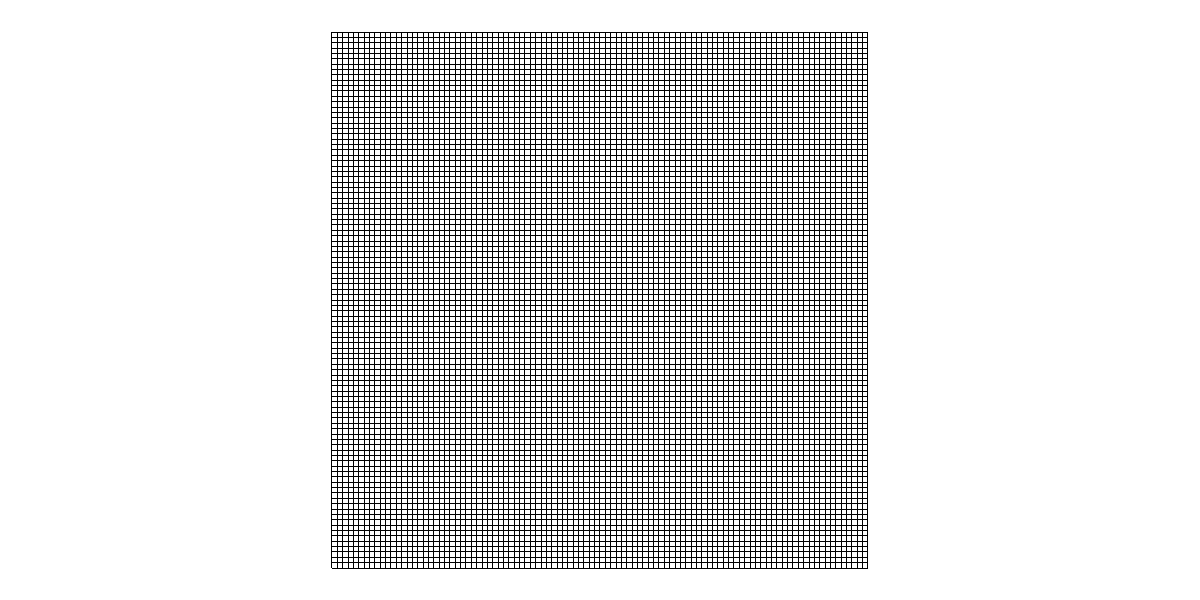

In [9]:
figMesh = glucifer.Figure(figsize=(1200,600),antialias=1)
#figMesh.append( glucifer.objects.Mesh(mesh.subMesh, nodeNumbers=True) )
figMesh.append( glucifer.objects.Mesh(mesh) )
figMesh.show()

In [10]:
thisaxis = 0

p_undeformed  = mesh.data[:mesh.elementRes[0] +1,:]
positions = [pos[0] for pos in p_undeformed]

mesh_nodes= np.arange(0, p_undeformed.shape[0] , 1)
edges = [(int(i), int(i+1)) for i in mesh_nodes[:-1]]
edge_rest_lengths = compute_edge_lengths( p_undeformed, edges )
new_lengths = edge_rest_lengths + 0.01*np.cos(np.pi*(np.array(positions[:-1])))
constraints = [ ( mesh_nodes[0], p_undeformed[ 0] ), ( mesh_nodes[-1], p_undeformed[-1] ) ]

p_initial = p_undeformed.copy()

In [11]:
p_solution = static_solution( p_initial, edges, new_lengths, constraints )

-- iteration 0 --
| F( p_n ) |^2: 0.000204835708416
| p_n+1 - p_n |^2: 5.065282779
-- iteration 1 --
| F( p_n ) |^2: 5.10542436591e-08
| p_n+1 - p_n |^2: 2.63951630205e-06


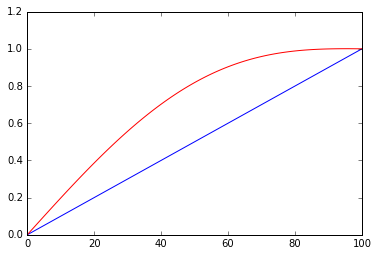

In [12]:
plt.plot(mesh_nodes, p_undeformed)
plt.plot(mesh_nodes, p_solution)

In [13]:
new_lengths  = np.array(edge_rest_lengths)
mid = new_lengths.shape[0]/2
old_dx = edge_rest_lengths[0]
new_lengths[0:mid ] *= 3.
#new_lengths[mid :] *= 1.001 ##weird, the matix goes singular when this is exactly 1.
new_lengths[mid :] *= 0.601 ##weird, the matix goes singular when this is exactly 1.

In [14]:
print(new_lengths.min(),new_lengths.max(), new_lengths.sum())

(0.0060099999999999381, 0.030000000000000027, 1.8005000000000007)


In [15]:
new_lengths

array([ 0.03   ,  0.03   ,  0.03   ,  0.03   ,  0.03   ,  0.03   ,
        0.03   ,  0.03   ,  0.03   ,  0.03   ,  0.03   ,  0.03   ,
        0.03   ,  0.03   ,  0.03   ,  0.03   ,  0.03   ,  0.03   ,
        0.03   ,  0.03   ,  0.03   ,  0.03   ,  0.03   ,  0.03   ,
        0.03   ,  0.03   ,  0.03   ,  0.03   ,  0.03   ,  0.03   ,
        0.03   ,  0.03   ,  0.03   ,  0.03   ,  0.03   ,  0.03   ,
        0.03   ,  0.03   ,  0.03   ,  0.03   ,  0.03   ,  0.03   ,
        0.03   ,  0.03   ,  0.03   ,  0.03   ,  0.03   ,  0.03   ,
        0.03   ,  0.03   ,  0.00601,  0.00601,  0.00601,  0.00601,
        0.00601,  0.00601,  0.00601,  0.00601,  0.00601,  0.00601,
        0.00601,  0.00601,  0.00601,  0.00601,  0.00601,  0.00601,
        0.00601,  0.00601,  0.00601,  0.00601,  0.00601,  0.00601,
        0.00601,  0.00601,  0.00601,  0.00601,  0.00601,  0.00601,
        0.00601,  0.00601,  0.00601,  0.00601,  0.00601,  0.00601,
        0.00601,  0.00601,  0.00601,  0.00601,  0.00601,  0.00

$$ \sum_i^N X_i = \beta $$
Where $X_i$ are the non-negative spring equilibriums positions
$$ min X_i = m$$
define
$$ \sum_i^N P_i = \sum_i^N \left( X_i + (X_i - m)\alpha \right) $$
We want 
$$ \sum_i^N P_i = 1$$
$$ \sum_i^N \left( X_i + (X_i - m)\alpha\right) = 1 $$
$$ \beta + \alpha \beta - \sum_i^N m\alpha = 1$$
$$ \beta + \alpha \beta - N m\alpha = 1$$
$$ \alpha \beta - N m\alpha = 1 - \beta $$
$$ \alpha = \frac{1 - \beta }{\beta - N m}$$

In [16]:
#normalizing function

beta = new_lengths.sum()
N = mesh.elementRes[0]

fm = min(new_lengths)
alpha = (1 - beta)/(beta - N*fm)
print(N, fm, beta, alpha)
norm_lengths = np.array(new_lengths) + ((np.array(new_lengths) - fm)*alpha)

(100, 0.0060099999999999381, 1.8005000000000007, -0.66736140058357318)


In [17]:
#norm_lengths

In [18]:
print(norm_lengths.min(),norm_lengths.max(), norm_lengths.sum())

(0.0060099999999999381, 0.013990000000000048, 0.99999999999999978)


In [19]:
thisaxis = 0

p_undeformed  = mesh.data[:mesh.elementRes[0] +1,:]
positions = [pos[0] for pos in p_undeformed]

mesh_nodes= np.arange(0, p_undeformed.shape[0] , 1)
edges = [(int(i), int(i+1)) for i in mesh_nodes[:-1]]
edge_rest_lengths = compute_edge_lengths( p_undeformed, edges )
#new_lengths = edge_rest_lengths + 0.01*np.cos(np.pi*(np.array(positions[:-1])))
constraints = [ ( mesh_nodes[0], p_undeformed[ 0] ), ( mesh_nodes[-1], p_undeformed[-1] ) ]

p_initial = p_undeformed.copy()

In [20]:
p_solution = static_solution( p_initial, edges, norm_lengths, constraints )

-- iteration 0 --
| F( p_n ) |^2: 9.55206e-05
| p_n+1 - p_n |^2: 1.326940335
-- iteration 1 --
| F( p_n ) |^2: 2.23668175018e-31


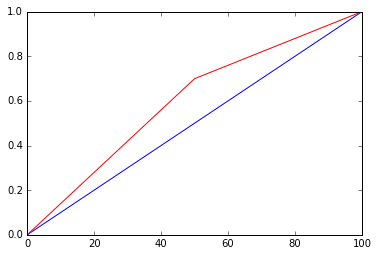

In [21]:
plt.plot(mesh_nodes, p_undeformed)
plt.plot(mesh_nodes, p_solution)

In [22]:
new_edge_rest_lengths = compute_edge_lengths(p_solution, edges )

Using dictionaries to map old coordinates to new coordinates is fine. But using coordinates as dictionary keys is crazy...we want to use the element number, as these are integer and unique.

So, we basically need a look-up function that maps an element index in the 1D mesh vector (m*n) to the value m, for instance.

In [23]:
mesh.data_elgId

array([[   0],
       [   1],
       [   2],
       ..., 
       [9997],
       [9998],
       [9999]], dtype=int32)

In [24]:
md = mesh.data[:,0].copy()
mesharray = md.reshape(mesh.elementRes[0] +1, mesh.elementRes[1] +1)

In [25]:
mesharray.shape

(101, 101)

In [26]:
#ykeys = np.zeros(mesh.data.size)
#ykeys = np.linspace(mesh.minCoord[1], mesh.maxCoord[1], mesh.elementRes[1] + 1)

#a = xkeys
#b = ykeys


#for j in range(mesh.elementRes[0]):
#        b = np.column_stack((b, ykeys))
    

In [27]:
mesh.data.size
#mesh.elementRes
(100*50)

5000

In [28]:
def mesh_element_keys(mesh):
    #xkeys = np.zeros(mesh.data.size)
    xkeys = np.linspace(mesh.minCoord[0], mesh.maxCoord[0], mesh.elementRes[0] + 1)
    #ykeys = np.zeros(mesh.data.size)
    ykeys = np.linspace(mesh.minCoord[1], mesh.maxCoord[1], mesh.elementRes[1] + 1)
    
    a = xkeys
    b = ykeys
    for i in range(mesh.elementRes[1]):
        a = np.row_stack((a, xkeys))
    for j in range(mesh.elementRes[0]):
        b = np.column_stack((b, ykeys))
    return a.flatten(), b.flatten()

In [29]:
xkeys, ykeys = mesh_element_keys(mesh)

In [30]:
xkeys.shape

(10201,)

In [31]:
ykeys.shape

(10201,)

In [32]:
origxcoords = np.linspace(mesh.minCoord[0], mesh.maxCoord[0], mesh.elementRes[0] + 1)
dictionary = dict(itertools.izip(origxcoords, p_solution[:,0]))
#assert len([x for x, y in collections.Counter(lest(p_solution).items() if y > 1]) == 0 #checks agains multiple coordinates


In [33]:
with mesh.deform_mesh():
    for index, coord in enumerate(mesh.data):
            key =  xkeys[index]
            mesh.data[index][0] = dictionary[key]


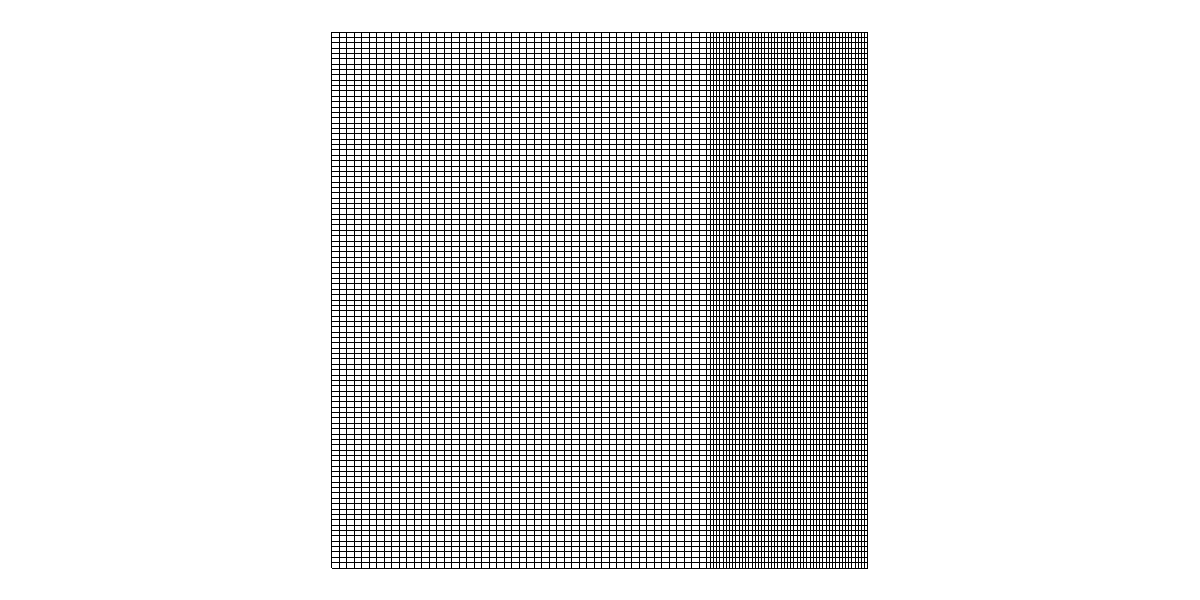

In [34]:
figMesh = glucifer.Figure(figsize=(1200,600),antialias=1)
#figMesh.append( glucifer.objects.Mesh(mesh.subMesh, nodeNumbers=True) )
figMesh.append( glucifer.objects.Mesh(mesh) )
figMesh.show()

## As a Function

In [35]:
mesh.maxCoord[0] - mesh.minCoord[0]

1.0

In [130]:
def deform_1d(f, mesh,axis = 'x',norm = 'None', constraints = []):
    """This function deforms the mesh along the given axis,
    by solving an anlogous spring system. The deformation is described by:
    f: function, or vector, giving the equilibrium spring lengths.
        If a function is given, the equilibrium positions are treated a function of space
        and the function solves for the current node/spring positions
        then remaps the spatial function onto the updated position
        If a vector is give, the equilibrium spring lengths are considered a fucntion of
        the springs themselves and only one equilibrium solve is needed
        (though this is still a non-linear system)
    axis: the axis to deform along, x or y
    norm: You can choose to normalise the function / vector in a couple of different ways:
        "None", vector / function isn.t normalised, spings will be in tension / compression
        "Uniform": vector / function is normalised to axis width uniformally
        "Min": vector / function is normalised to axis width, while preserving the min separation
    constraints: extra constraints for the system (the mesh never changes size, but inernal nodel can be fixed)
    """
    xkeys, ykeys = mesh_element_keys(mesh)
    if axis == "y":
        thisaxis = 1
        usekeys = ykeys
    else:
        thisaxis = 0
        usekeys = xkeys
    print(norm)
    if not callable(f):
        #Sort out normalisation
        if norm == 'None':
            pass
        elif norm == 'Uniform':
            f = f/f.sum()
        elif norm == 'Min':
            beta = f.sum()
            N = mesh.elementRes[thisaxis]
            fm = min(f)
            alpha = ((mesh.maxCoord[thisaxis] - mesh.minCoord[thisaxis]) - beta)/(beta - N*fm)
            print(N, fm, beta, alpha)
            f = np.array(f) + ((np.array(f) - fm)*alpha)
        #p_undeformed  = mesh.data[:mesh.elementRes[ thisaxis] +1,:] #This need fixing
        p_undeformed  = np.array(zip(np.linspace(mesh.minCoord[thisaxis], mesh.maxCoord[thisaxis],
                                        mesh.elementRes[thisaxis] + 1), np.zeros(mesh.elementRes[thisaxis] + 1 )))


        mesh_nodes= np.arange(0, p_undeformed.shape[ 0] , 1)

        edges = [(int(i), int(i+1)) for i in mesh_nodes[:-1]]
        constraints = [ ( mesh_nodes[0], p_undeformed[ 0] ), ( mesh_nodes[-1], p_undeformed[-1] ) ] + constraints#Add egde constraints
        p_initial = p_undeformed.copy()
        print ('edges', len(edges))
        p_solution = static_solution( p_initial, edges, f, constraints )
        origxcoords = np.around(np.linspace(mesh.minCoord[thisaxis ], mesh.maxCoord[thisaxis ], mesh.elementRes[thisaxis ] + 1), 5)
        dictionary = dict(itertools.izip(origxcoords, p_solution[:,0]))
        #print dictionary
        with mesh.deform_mesh():
            for index, coord in enumerate(mesh.data):
                mesh.data[index][thisaxis] = dictionary[np.around(coord,5)[thisaxis]]
        #Print some stats
        print("Min, Max element width: ")
        print("%.5f" % min(compute_edge_lengths(p_solution, edges )))
        print("%.5f" % max(compute_edge_lengths(p_solution, edges )))

In [150]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (100, 50), 
                                 minCoord    = (-1., 0.), 
                                 maxCoord    = (1., 1.1))


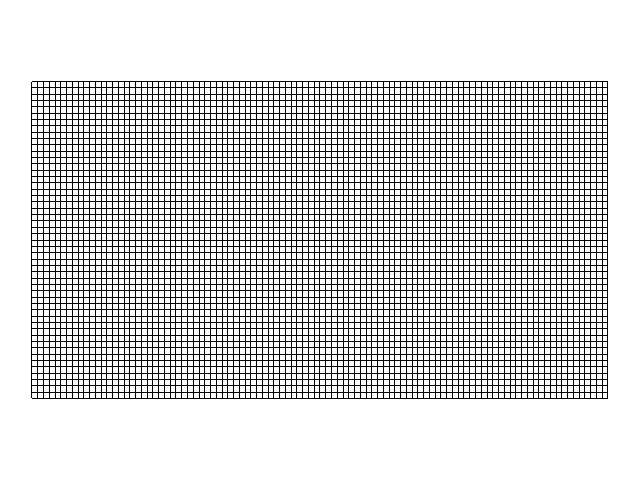

In [151]:
figMesh = glucifer.Figure()
#figMesh.append( glucifer.objects.Mesh(mesh.subMesh, nodeNumbers=True) )
figMesh.append( glucifer.objects.Mesh(mesh) )
figMesh.show()

In [152]:
new_lengths.shape[0]/2

50

In [153]:
mesh.reset()

In [154]:
p_undeformed  = mesh.data[:mesh.elementRes[0] +1,:]
mesh_xs= np.arange(0, p_undeformed.shape[0] , 1)
edges = [(int(i), int(i+1)) for i in mesh_xs[:-1]]
edge_rest_lengths = compute_edge_lengths( p_undeformed, edges )
new_lengths  = np.array(edge_rest_lengths)
mid = new_lengths.shape[0]/2
old_dx = edge_rest_lengths[0]
third = new_lengths.shape[0]/3
#new_lengths[:third] *= 2.
#new_lengths[third:] *= 2.
new_lengths[third:2*third] *= 0.5 ##weird, the matix goes singular when this is exactly 1.


In [155]:
origxcoords = np.linspace(mesh.minCoord[thisaxis ], mesh.maxCoord[thisaxis ], mesh.elementRes[thisaxis ] + 1)
np.around(origxcoords, 3)

array([ 0.   ,  0.022,  0.044,  0.066,  0.088,  0.11 ,  0.132,  0.154,
        0.176,  0.198,  0.22 ,  0.242,  0.264,  0.286,  0.308,  0.33 ,
        0.352,  0.374,  0.396,  0.418,  0.44 ,  0.462,  0.484,  0.506,
        0.528,  0.55 ,  0.572,  0.594,  0.616,  0.638,  0.66 ,  0.682,
        0.704,  0.726,  0.748,  0.77 ,  0.792,  0.814,  0.836,  0.858,
        0.88 ,  0.902,  0.924,  0.946,  0.968,  0.99 ,  1.012,  1.034,
        1.056,  1.078,  1.1  ])

In [156]:
def find_closest(A, target):
    #A must be sorted
    idx = A.searchsorted(target)
    idx = np.clip(idx, 1, len(A)-1)
    left = A[idx-1]
    right = A[idx]
    idx -= target - left < right - target
    return idx

In [157]:
orgs = np.unique(mesh.data[:,1])

value_to_constrain = 1.


yconst = [(find_closest(orgs, value_to_constrain), np.array([1.,0]))]
yconst 

[(45, array([ 1.,  0.]))]

In [158]:
deform_1d(new_lengths, mesh,axis = 'x',norm = 'Min', constraints = [])

Min
(100, 0.0099999999999998979, 1.6699999999999999, 0.49253731343282847)
('edges', 100)
-- iteration 0 --
| F( p_n ) |^2: 0.000494052127423
| p_n+1 - p_n |^2: 0.908927378035
-- iteration 1 --
| F( p_n ) |^2: 3.12771022968e-31
Min, Max element width: 
0.01000
0.02493


In [159]:
new_lengths.min(), new_lengths.max()

(0.0099999999999998979, 0.020000000000000018)

In [160]:
#Y-Axis
axis = 1
origcoords = np.linspace(mesh.minCoord[axis], mesh.maxCoord[axis], mesh.elementRes[axis] + 1)
edge_rest_lengths = np.diff(origcoords)
third = edge_rest_lengths.shape[0]/3
deform_lengths = np.copy(edge_rest_lengths)
deform_lengths

deform_lengths[2*third:] *= 0.5001 ##The matix can go singular when this is exactly 1.
deform_1d(deform_lengths, mesh, axis = 'y',norm = 'Uniform', constraints = yconst )

Uniform
('edges', 50)
-- iteration 0 --
| F( p_n ) |^2: 0.000850454922105
| p_n+1 - p_n |^2: 0.22128012082
-- iteration 1 --
| F( p_n ) |^2: 0.000104296519003
| p_n+1 - p_n |^2: 1.7976268989e-30
Min, Max element width: 
0.01355
0.02574



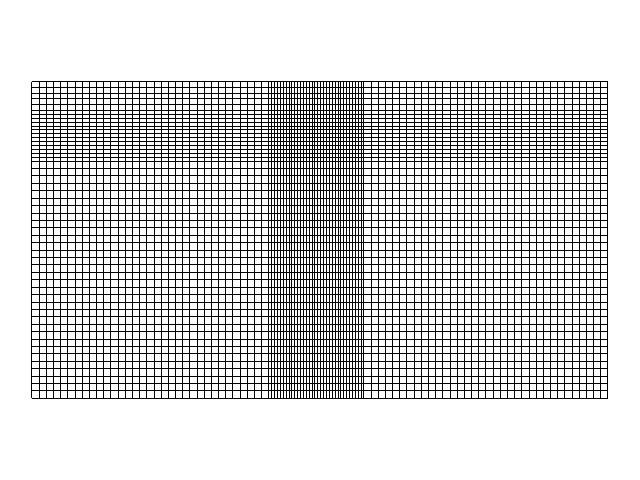

In [161]:
figMesh.save_database('test.gldb')
figMesh.show()


In [85]:
mesh_nodes[0], p_undeformed[ 0] 

(0, array([-1.,  0.]))

In [92]:
orgs = np.unique(mesh.data[:,1])

In [100]:
def find_closest(A, target):
    #A must be sorted
    idx = A.searchsorted(target)
    idx = np.clip(idx, 1, len(A)-1)
    left = A[idx-1]
    right = A[idx]
    idx -= target - left < right - target
    return idx

In [101]:
find_closest(orgs, 1.)

43

In [99]:
orgs.shape

(51,)

In [106]:
constraints = [ ( mesh_nodes[0], p_undeformed[ 0] ), ( mesh_nodes[-1], p_undeformed[-1] ) ]

In [109]:
constraints.append((43, np.array([1.,0])))

In [110]:
constraints

[(0, array([-1.,  0.])), (100, array([ 1.,  0.])), (43, array([ 1.,  0.]))]

In [118]:
constraints + constraints

[(0, array([-1.,  0.])),
 (100, array([ 1.,  0.])),
 (43, array([ 1.,  0.])),
 (0, array([-1.,  0.])),
 (100, array([ 1.,  0.])),
 (43, array([ 1.,  0.]))]